In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

global first_layer
first_layer = 1

global res 
res = None

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )

        # Skip the layer
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 16,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.fc = nn.Linear(128, num_classes)

    # Initialize the layer
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        global first_layer
        global res 

        out = self.conv1(x)
        out = self.layer1(out)
        if(first_layer == 1):
          #print("First layer")
          #print(out)
          res = out
          first_layer += 1
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

# Task 2
Plot the loss and acc at each iteration and epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

# check if cuda is available, if not just use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# configuration of parameters
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--outf', default='./model/', help='folder to output images and model checkpoints') 
args = parser.parse_args([])

# configuration of hyperparameters
EPOCH = 5  
pre_epoch = 0  
BATCH_SIZE = 128     
LR = 0.01       

# prepare the dataset and preprocessing
# use mean and variance to normalize
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Get dataset online
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Cifar-10 labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# define a resnet
net = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()  

#optimize with mini-batch momentum-SGD using L2-normalization
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) 

best_acc = 85 

print("Start Training...")

for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        # preparing for data
        length = len(trainloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print out the loss and acc for every batch 
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))

    # after each epoch print out the acc
    print("Waiting Test!")
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test acc：%.3f%%' % (100 * correct / total))
        acc = 100. * correct / total

print("Training Finished, TotalEPOCH=%d" % EPOCH)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Start Training, Resnet-18!

Epoch: 1
[epoch:1, iter:1] Loss: 2.331 | Acc: 10.938% 
[epoch:1, iter:2] Loss: 2.352 | Acc: 10.938% 
[epoch:1, iter:3] Loss: 2.359 | Acc: 10.156% 
[epoch:1, iter:4] Loss: 2.356 | Acc: 11.523% 
[epoch:1, iter:5] Loss: 2.340 | Acc: 12.500% 
[epoch:1, iter:6] Loss: 2.335 | Acc: 12.109% 
[epoch:1, iter:7] Loss: 2.327 | Acc: 12.612% 
[epoch:1, iter:8] Loss: 2.318 | Acc: 12.988% 
[epoch:1, iter:9] Loss: 2.309 | Acc: 13.802% 
[epoch:1, iter:10] Loss: 2.298 | Acc: 13.906% 
[epoch:1, iter:11] Loss: 2.296 | Acc: 13.849% 
[epoch:1, iter:12] Loss: 2.289 | Acc: 13.477% 
[epoch:1, iter:13] Loss: 2.282 | Acc: 13.702% 
[epoch:1, iter:14] Loss: 2.270 | Acc: 14.230% 
[epoch:1, iter:15] Loss: 2.255 | Acc: 14.896% 
[epoch:1, iter:16] Loss: 2.245 | Acc: 15.088% 
[epoch:1, iter:17] Loss: 2.238 | Acc: 15.074% 
[epoch:1, iter:18] Loss: 2.228 | Acc: 15.538% 
[epoch:1, iter:19] Loss: 2.217 | Acc:

best_acc= 96.285%

In this src file, we just set the epoch = 5 for quick execution. While we were training the model, we have set epoch = 135 and it takes ~ 54min. You can check the changes of acc from the sreenshot in the zip-file.

In [ ]:
print(net.layer1)

Sequential(
  (0): ResidualBlock(
    (left): Sequential(
      (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): ResidualBlock(
    (left): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
# Get the first CNN layer
print(list(list(net.layer1[0].children())[0].children())[0])
first_filter = list(list(net.layer1[0].children())[0].children())[0].weight

Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


# Task 1
Plot the filters of the first layer

torch.Size([128, 16, 32, 32])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.5124e-01],
          [0.0000e+00, 0.0000e+00, 2.8847e-01,  ..., 1.6369e+00,
           2.0218e+00, 1.4376e-01],
          [0.0000e+00, 8.4329e-01, 1.4488e+00,  ..., 2.6947e+00,
           3.2912e+00, 1.3402e+00],
          ...,
          [3.8574e-01, 1.5705e+00, 6.9407e-01,  ..., 1.7895e+00,
           2.2566e+00, 7.4816e-01],
          [2.7489e+00, 3.1208e+00, 2.0009e+00,  ..., 0.0000e+00,
           1.6437e+00, 0.0000e+00],
          [1.5551e+00, 1.1544e+00, 1.2164e-01,  ..., 6.1860e-03,
           9.8711e-01, 0.0000e+00]],

         [[1.2969e+00, 1.0030e+00, 1.1965e+00,  ..., 7.8604e-02,
           5.9599e-02, 1.9262e+00],
          [8.3922e-01, 1.5745e-01, 7.3853e-01,  ..., 0.0000e+00,
           2.5838e-03, 9.6541e-01],
          [1.2438e+00, 0.0000e+00, 7.1265e-01,  ..., 0.0000e+00,
           0.0000e+00, 6.8668e-01],
          ...,
          [2.0214e+00, 0.0000

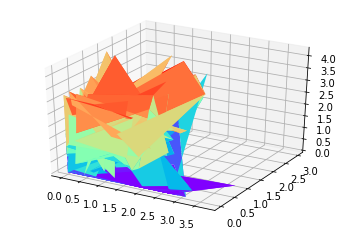

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

global res
print(res.size())
print(res)

# torchvision.utils.make_grid(res)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range (0,128):
    z = res[i]
    ax.plot_surface(z.cpu().detach().numpy()[0],z.cpu().detach().numpy()[1],z.cpu().detach().numpy()[2],cmap='rainbow')
    plt.show()

In [ ]:
# visualize the first conv layer filters
def virtualize(color):
  plt.figure(figsize=(20, 17))
  for i, filter in enumerate(first_filter):
    # (4, 4) because in conv0 we have 3x3 filters and total of 16 (see printed shapes)
    plt.subplot(4, 4, i+1) 
    plt.imshow(filter[0, :, :].cpu().detach(), cmap=color)
    plt.axis('off')
  plt.show()

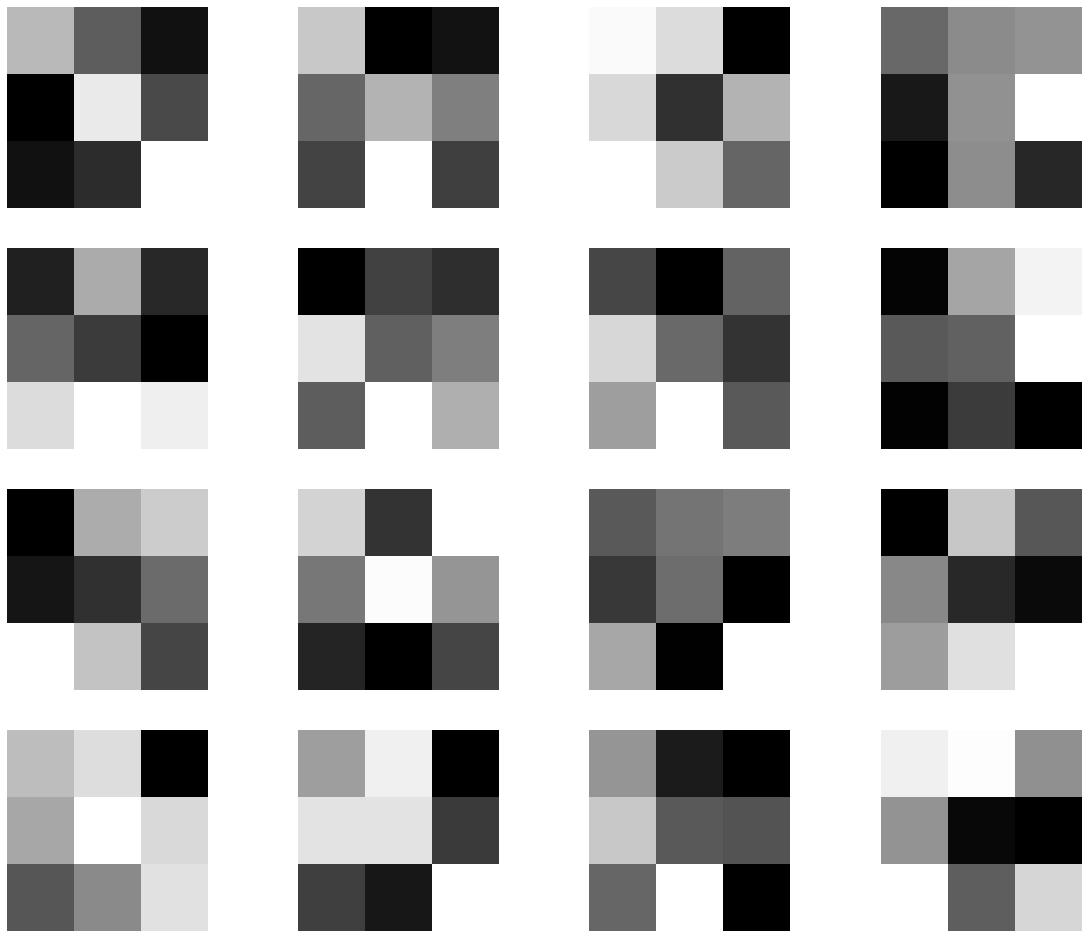

In [ ]:
virtualize("gray")

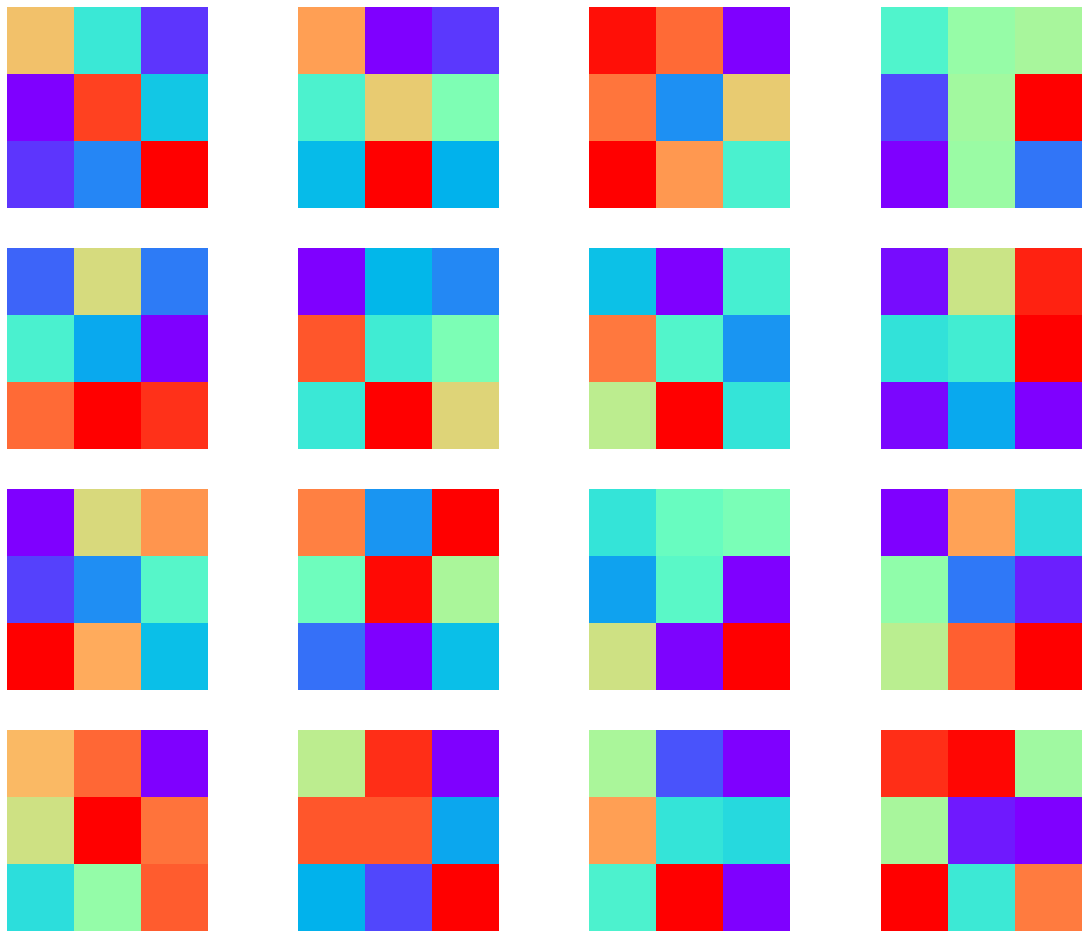

In [ ]:
virtualize("rainbow")

# Task 3
Is deeper always better? 

The accuracy will be reduced sometimes. Observed that in the 45th epoch, the accuracy has following changes: 92.5% --> 92.4% --> 92.5% --> 92.7% --> 92.4%.
Arround 50th epoch, the accuracy fluctuates between 94% and 95%. When acc approches 90%, the increasing rate will much slower compared to the beginning of training. Sometimes when the network comes deeper, the phenomenon degradation will happen(loss will be increased which is actually not overfitting because overfitting leads to decreasing of loss) and the gradient will be closer to 0.